<h1>Ice temperature forecast modeling based on a simple neural network</h1>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

import sys
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler

plt.style.use('dark_background')

In [3]:
# %cd project/dl_phd_project

# Creating a data loader

In [3]:
class TimeSeriesDataset(Dataset):
    def __init__(self, path, seq_length, step_size, split='train', train_size=0.7, val_size=0.15, scaler=None):
        '''
        Args:
            path (str): path to csv file with data
            seq_length (int): sequence length for input data
            step_size (int): steps count forward for prediction (horizon)
            split (str): type of sample ('train', 'val', 'test')
            train_size (float): data proportion for train sample
            val_size (float): data proportion for val sample -> test_size = 1 - train_size - val_size
            scaler (sklearn.preprocessing)
        '''
        
        self.features = ['temp_ice']
        self.data = pd.read_csv(path, usecols=['time'] + self.features)
        self.seq_length = seq_length
        self.step_size = step_size
        self.scaler = scaler

        # split train, validation and test sampling
        n = len(self.data)
        train_end = int(n * train_size)
        val_end = train_end + int(n * val_size)

        if split == 'train':
            self.data = self.data[:train_end]
            self.scaler = MinMaxScaler()
            self.scaler.fit(self.data[['temp_ice']])
    
        elif split == 'val':
            self.data = self.data[train_end:val_end]
        elif split == 'test':
            self.data = self.data[val_end:]
        else:
            raise ValueError('split must be "train", "val" or "test"')


        # define weights for loss function
        self.weights = self.data['temp_ice'].diff(1).fillna(0)**4
        self.weights = self.weights.values

        if self.scaler is not None:
            self.data[['temp_ice']] = self.scaler.transform(self.data[['temp_ice']])
        else:
            raise ValueError('Scaler not defined, create a train_dataset instance for it')
        

    def __len__(self):
        return len(self.data) - self.seq_length - self.step_size + 1
    

    def __getitem__(self, idx):
        x = self.data.iloc[idx: idx + self.seq_length][['temp_ice']].values
        y = self.data.iloc[idx + self.seq_length + self.step_size - 1]['temp_ice']

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    

path = '../data/small_data.csv'
seq_length = 60
step_size = 30
batch_size = 128

train_dataset = TimeSeriesDataset(path, seq_length, step_size, split='train', train_size=0.7, val_size=0.15)
val_dataset = TimeSeriesDataset(path, seq_length, step_size, split='val', train_size=0.7, val_size=0.15, scaler=train_dataset.scaler)
test_dataset = TimeSeriesDataset(path, seq_length, step_size, split='test', train_size=0.7, val_size=0.15, scaler=train_dataset.scaler)

In [4]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Creating a model

In [9]:
class SimpleModel(nn.Module):
    def __init__(self, seq_length, num_features, output_size):
        super().__init__()
        self.seq_length = seq_length
        self.linear_1 = nn.Linear(seq_length * num_features, 128)
        self.linear_2 = nn.Linear(128, 32)
        self.linear_3 = nn.Linear(32, output_size)
        self.act = nn.ReLU()
    

    def forward(self, x):
        x = self.linear_1(x)
        x = self.act(x)
        x = self.linear_2(x)
        x = self.act(x)
        x = self.linear_3(x)

        return x



num_features = len(train_dataset.features)

model = SimpleModel(seq_length, num_features, 1).to(device)
mse_loss_model = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5)

In [10]:
str_info = '''
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear_1 = nn.Linear(seq_length * input_size, 128)
        self.linear_2 = nn.Linear(128, 32)
        self.linear_3 = nn.Linear(32, output_size)
        self.act = nn.ReLU()
    

    def forward(self, x):
        x = self.linear_1(x)
        x = self.act(x)
        x = self.linear_2(x)
        x = self.act(x)
        x = self.linear_3(x)

        return x
'''

EPOCHS = 50
save_epoch = 0
train_loss = []
train_metric = []
val_loss = []
val_metric = []
lr_list = []
best_loss = None
features = train_dataset.features

checkpoint = {
    'info': str_info,
    'features': features,
    'seq_length': seq_length,
    'state_model': model.state_dict(),
    'state_opt': opt.state_dict(),
    'state_lr_scheduler': lr_scheduler.state_dict(),
    'loss': {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'best_loss': best_loss
    },
    'metric': {
        'train_metric': train_metric,
        'val_metric': val_metric
    },
    'lr': 'lr_list',
    'epoch': {
        'EPOCHS': EPOCHS,
        'save_epoch': save_epoch
    }
}

# Train model

In [ ]:
# training cycle
for epoch in range(save_epoch, EPOCHS):

    # model training
    model.train()
    running_train_loss = []
    running_train_metric = []
    train_loop = tqdm(train_loader, leave=False, file=sys.stdout)
    for X, y in train_loop:
        # (batch_size, seq_length)
        X = X.reshape(batch_size, seq_length * num_features).to(device)
        y = y.reshape(batch_size, -1).to(device)

        # forward + calculation loss
        y_pred = model(X)
        mse_loss = mse_loss_model(y_pred, y)
        mae_metric = torch.abs(y_pred - y).mean()

        # backward
        opt.zero_grad()
        mse_loss.backward()
    
        # optimization step
        opt.step()


        running_train_loss.append(mse_loss.item())
        running_train_metric.append(mae_metric.item())

        mean_train_loss = sum(running_train_loss) / len(running_train_loss)
        mean_train_metric = sum(running_train_metric) / len(running_train_metric)

        train_loop.set_description(f'Epoch [{epoch + 1}/{EPOCHS}], train_loss={mean_train_loss:.4f}')
    
    
    train_loss.append(mean_train_loss)
    train_metric.append(mean_train_metric)

    # model validating
    model.eval()
    with torch.no_grad():
        running_val_loss = []
        running_val_metric = []
        for X, y in val_loader:
            X = X.reshape(batch_size, seq_length * num_features).to(device)
            y = y.reshape(batch_size, -1).to(device)

            # forward
            y_pred = model(X)
            mse_loss = mse_loss_model(y_pred, y)
            mae_metric = torch.abs(y_pred - y).mean()

            running_val_loss.append(mse_loss.item())
            running_val_metric.append(mae_metric.item())

            mean_val_loss = sum(running_val_loss) / len(running_val_loss)
            mean_val_metric = sum(running_val_metric) / len(running_val_metric)
        
        val_loss.append(mean_val_loss)
        val_metric.append(mean_val_metric)
        

    lr_scheduler.step(mean_val_loss)
    lr = lr_scheduler._last_lr[0]
    lr_list.append(lr)

    print(f'Epoch [{epoch + 1}/{EPOCHS}], ' 
          f'train_loss={mean_train_loss:.4f}, train_metric={mean_train_metric:.4f}, '
          f'val_loss={mean_val_loss:.4f}, val_metric={mean_train_metric:.4f}')


    if best_loss is None or mean_val_loss < best_loss:
        best_loss = mean_val_loss
        count = 0

        checkpoint = {
            'info': str_info,
            'features': features,
            'state_model': model.state_dict(),
            'state_opt': opt.state_dict(),
            'state_lr_scheduler': lr_scheduler.state_dict(),
            'loss': {
                'train_loss': train_loss,
                'val_loss': val_loss,
                'best_loss': best_loss
            },
            'metric': {
                'train_metric': train_metric,
                'val_metric': val_metric
            },
            'lr': lr_list,
            'epoch': {
                'EPOCHS': EPOCHS,
                'save_epoch': epoch
            }
        }

        torch.save(checkpoint, f'../models/simple_dnn_model_checkpoint.pt')
        print(f'On epoch - {epoch + 1}, the model with the value of the validation loss function is saved - {mean_val_loss:.4f}', end='\n\n')
    

    if count >= 10:
        print(f'\033[31m Training stopped at epoch {epoch + 1}.\033[0m')
        break

    count += 1


Epoch [1/50], train_loss=0.0225, train_metric=0.1162, val_loss=0.0134, val_metric=0.1162
On epoch - 1, the model with the value of the validation loss function is saved - 0.0134

Epoch [2/50], train_loss=0.0154, train_metric=0.0941, val_loss=0.0117, val_metric=0.0941
On epoch - 2, the model with the value of the validation loss function is saved - 0.0117

Epoch [3/50], train_loss=0.0143, train_metric=0.0894, val_loss=0.0107, val_metric=0.0894
On epoch - 3, the model with the value of the validation loss function is saved - 0.0107

Epoch [4/50], train_loss=0.0136, train_metric=0.0864, val_loss=0.0099, val_metric=0.0864
On epoch - 4, the model with the value of the validation loss function is saved - 0.0099

Epoch [5/50], train_loss=0.0134, train_metric=0.0860, val_loss=0.0093, val_metric=0.0860
On epoch - 5, the model with the value of the validation loss function is saved - 0.0093

Epoch [6/50], train_loss=0.0126, train_metric=0.0820, val_loss=0.0092, val_metric=0.0820
On epoch - 6, th

# Model check

In [5]:
load_model_state = torch.load('../models/simple_dnn_model_checkpoint.pt', map_location=torch.device('cpu'))

In [9]:
load_model_state.keys()


dict_keys(['info', 'features', 'state_model', 'state_opt', 'state_lr_scheduler', 'loss', 'metric', 'lr', 'epoch'])

In [23]:
train_loss = load_model_state['loss']['train_loss']
val_loss = load_model_state['loss']['val_loss']
train_metric = load_model_state['metric']['train_metric']
val_metric = load_model_state['metric']['val_metric']
lr_list = load_model_state['lr']

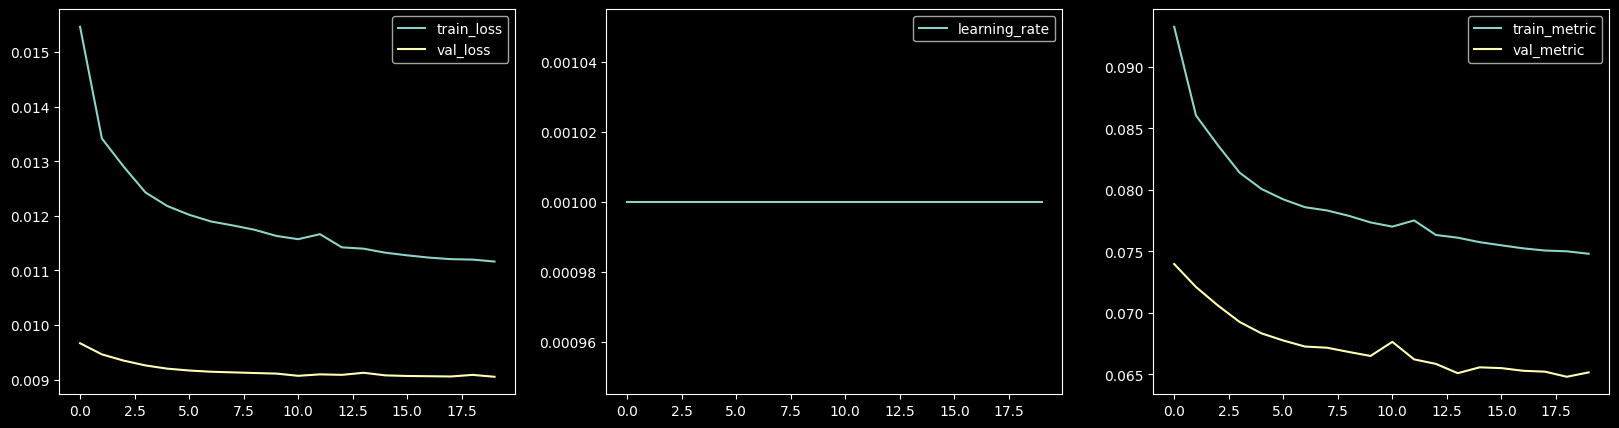

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.plot(train_loss)
ax1.plot(val_loss)
ax1.legend(['train_loss', 'val_loss'])

ax2.plot(lr_list)
ax2.legend(['learning_rate'])

ax3.plot(train_metric)
ax3.plot(val_metric)
ax3.legend(['train_metric', 'val_metric'])

In [ ]:
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear_1 = nn.Linear(seq_length * input_size, 128)
        self.linear_2 = nn.Linear(128, 32)
        self.linear_3 = nn.Linear(32, output_size)
        self.act = nn.ReLU()
    

    def forward(self, x):
        x = self.linear_1(x)
        x = self.act(x)
        x = self.linear_2(x)
        x = self.act(x)
        x = self.linear_3(x)

        return x


seq_length = 60
num_features = len(load_model_state['features'] * seq_length)
model = SimpleModel(seq_length * num_features, 1)

model.load_state_dict(load_model_state['state_model'])

In [18]:
# y = []
# y_pred = []

# model.eval()
# with torch.no_grad():
#     running_test_loss = []
#     true_answer = 0
#     for x, targets in test_loader:
#         x = x.reshape(16, seq_length).to(device)
#         targets = targets.reshape(16, -1).to(device)

#         pred = model(x)
#         loss = loss_model(pred, targets).mean()

#         running_test_loss.append(loss.item())
#         mean_test_loss = sum(running_test_loss) / len(running_test_loss)

#         y.extend(torch.squeeze(targets).tolist())
#         y_pred.extend(torch.squeeze(pred).tolist())

#     print(f'test_loss={mean_test_loss:.4f}')

test_loss=0.0223


In [109]:
# # y = np.array(y).reshape(-1, 1)
# y = np.array([y, y]).T
# y_pred = np.array([y_pred, y_pred]).T

In [110]:
# y = train_dataset.scaler.inverse_transform(y)[:, [0]].reshape(-1, 1)
# y_pred = train_dataset.scaler.inverse_transform(y_pred)[:, [0]].reshape(-1, 1)

In [111]:
# result = pd.DataFrame({'temp_ice': y.flatten(), 'pred_temp_ice': y_pred.flatten()})
# result.head()

,temp_ice,pred_temp_ice
0,-0.9075,0.038157
1,-0.9450,0.062022
2,-0.9600,0.070911
3,-0.9375,0.044634
4,-0.9075,-0.017768


In [113]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

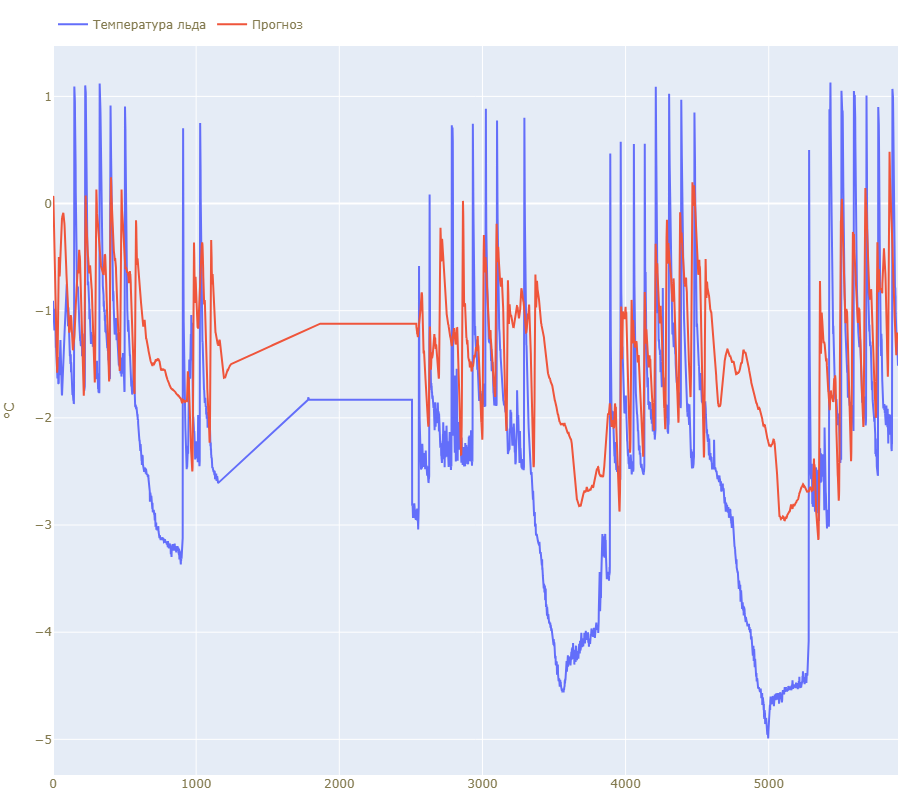

In [115]:
# fig = make_subplots(rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.02)
# fig.add_trace(go.Scatter(y=result['temp_ice'], name='Температура льда'), row=1, col=1)
# fig.add_trace(go.Scatter(y=result['pred_temp_ice'], name='Прогноз'), row=1, col=1)
# fig.update_layout(margin=dict(l=10, r=10, t=30, b=10),
#                   legend=dict(orientation='h', yanchor='bottom', x=0, y=1.01),
#                 #   width=1000,
#                   height=800,
#                   font_color="#837A4F",
#                   title_font_color="#837A4F")
# fig.update_traces(hoverinfo='all', hovertemplate='Дата и время: %{x}<br>Температура: %{y:.2f}°C', row=1, col=1)
# fig.update_yaxes(title_text='°C', row=1, col=1)